In [1]:
from liblet import ANTLR, Stack, Tree

# Occhio a ricorsione e precedenza

## Operatori aritmetici

In [2]:
expr = '1 + 2 * 3'

In [3]:
MulProd = ANTLR(r"""
grammar MulProd; ignoblebug: expr;
 
expr: expr '*' expr
    | expr '+' expr
    | NUM
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

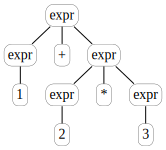

In [4]:
multprod_parse_tree = MulProd.as_lol(MulProd.tree(expr, 'expr'))
Tree.from_lol(multprod_parse_tree)

In [7]:
MulProdWrong = ANTLR(r"""
grammar MulPordWrong; ignoblebug: expr;
 
expr: expr '+' expr
    | expr '*' expr
    | NUM
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

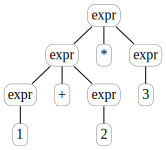

In [8]:
Tree.from_lol(MulProdWrong.as_lol(MulProdWrong.tree(expr, 'expr')))

## Dangling else

In [9]:
source = r"""
if e0 then
    if e1 then
        i0
    else
        i1
"""

LEXER = r"""
ISTR: 'i' [0-9]* ;
EXPR: 'e' [0-9]* ;
WS: [ \t\n\r]+ -> skip ;
"""

In [10]:
IfElse = ANTLR(r"""
grammar IfElse;

stat:   'if' EXPR 'then' stat
    |   'if' EXPR 'then' stat 'else' stat
    |   ISTR
    ;
    
""" + LEXER)

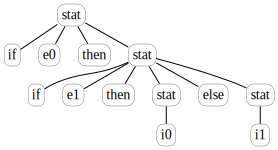

In [11]:
Tree.from_lol(IfElse.as_lol(IfElse.tree(source, 'stat')))

In [12]:
IfElseWrong = ANTLR(r"""
grammar IfElseWrong;

stat:   'if' EXPR 'then' stat 'else' stat
    |   'if' EXPR 'then' stat
    |   ISTR
    ;
    
""" + LEXER)

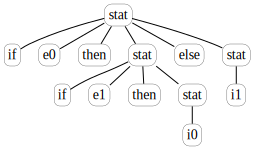

In [13]:
Tree.from_lol(IfElseWrong.as_lol(IfElseWrong.tree(source, 'stat')))

In [14]:
IfElse = ANTLR(r"""
grammar IfElse;

stat:   'if' EXPR 'then' stat ('else' stat)?
    |   ISTR
    ;
    
""" + LEXER)

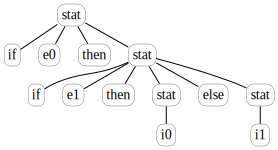

In [15]:
Tree.from_lol(IfElse.as_lol(IfElse.tree(source, 'stat')))

# Raccogliere informazioni

## Nei nodi

Alberi con *attributi*

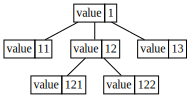

In [16]:
tree = [{'value': 1}, 
           [{'value': 11}], 
           [{'value': 12}, 
               [{'value': 121}], 
               [{'value': 122}]
           ], 
           [{'value': 13}]
       ]

Tree.from_lol(tree)

### Ededitati

I sottoalberti ricevono il valore dalla radice (tramite una visita in pre-ordine).

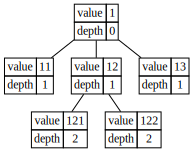

In [17]:
def update_depth(parent, tree):
    root, *children = tree
    root['depth'] = parent['depth'] + 1
    for st in children: update_depth(root, st)

update_depth({'depth': -1}, tree)        

Tree.from_lol(tree)

### Derivati, o sintetizzati

La radice deriva l'attributo da quelli dei sottoalberi (tramite una visita in post-ordine).

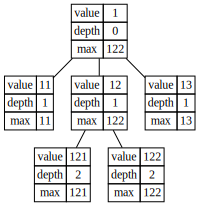

In [20]:
def update_max(tree):
    root, *children = tree
    if not children: root['max'] = int(root['value'])
    else:
        for st in children: update_max(st)
        root['max'] = max(st[0]['max'] for st in children)

update_max(tree)

Tree.from_lol(tree)

## In strutture dati esterne

Le informazioni non sono contenute nei nodi, ma in una struttura dati globale.

In [21]:
ODD_MAX_NODES = []

def update_ovn(tree):
    root, *children = tree
    if root['max'] % 2 == 1: ODD_MAX_NODES.append(root)
    for child in children: update_ovn(child)
        
update_ovn(tree)

ODD_MAX_NODES

[{'value': 11, 'depth': 1, 'max': 11},
 {'value': 121, 'depth': 2, 'max': 121},
 {'value': 13, 'depth': 1, 'max': 13}]

# Parse Tree e Abstract Syntax Tree

Il *parse tree* è il risultato del parsing, l'*AST* è un albero (annotato) che descrive più fedelmente la "semantica" che attribuiamo al linguaggio.

['expr', ['expr', ['1']], ['+'], ['expr', ['expr', ['2']], ['*'], ['expr', ['3']]]]


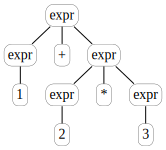

In [22]:
# parse tree

print(multprod_parse_tree)
Tree.from_lol(multprod_parse_tree)

## AST dal Parse Tree

In [23]:
def to_ast(tree):
    if len(tree) == 2:
        root, value = tree
        return [{'type': 'const', 'value': int(value[0])}]
    root, left, op, right = tree
    if root == 'expr':
        return [{'type': 'op', 'kind': op[0]}, to_ast(left), to_ast(right)]

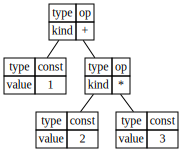

In [24]:
mulprod_ast = to_ast(multprod_parse_tree)    
Tree.from_lol(mulprod_ast)

## AST durante il parsing

Oltre che ottenerlo dal parse tree, si può costruire durante il parsing (gestendo a mano uno stack… **orrore**)

In [25]:
MulPordAST = ANTLR(r"""
grammar MulPordAST; 

@header {
from liblet import Stack 
}

@members {
    self.STACK = Stack()
}

ignoblebug: expr;

expr: expr '*' expr {self.STACK.push([{'type': 'op', 'kind': '*'}, self.STACK.pop(), self.STACK.pop()])}
    | expr '+' expr {self.STACK.push([{'type': 'op', 'kind': '+'}, self.STACK.pop(), self.STACK.pop()])}
    | NUM {self.STACK.push([{'type': 'const', 'value': $NUM.int}])}
    ;

NUM: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
""")

In [26]:
r = MulPordAST.tree('2 + 3 * 4', 'expr', buildParseTrees = False)
mulprod_ast = r.parser.STACK.pop()

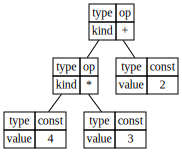

In [27]:
Tree.from_lol(mulprod_ast)

# Usare l'AST

## Annotando

14


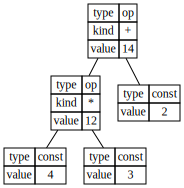

In [28]:
# il valore è sintetizzato, quindi uso una visita in post-ordine

def update_value(tree):
    root, *children = tree
    if root['type'] == 'op':
        left, right = children
        update_value(left)
        update_value(right)
        if root['kind'] == '+':
            root['value'] = left[0]['value'] + right[0]['value']
        else:
            root['value'] = left[0]['value'] * right[0]['value']
        
update_value(mulprod_ast)
print(mulprod_ast[0]['value'])
Tree.from_lol(mulprod_ast)

## Usando una struttura dati esterna

In [29]:
STACK = Stack()

def expr_eval(tree):
    root, *children = tree
    if root['type'] == 'op':
        left, right = children
        expr_eval(left)
        expr_eval(right)
        if root['kind'] == '+':
            STACK.push(STACK.pop() + STACK.pop())
        else:
            STACK.push(STACK.pop() * STACK.pop())
    else: # type == const
        STACK.push(root['value'])

expr_eval(mulprod_ast)
STACK.pop()

14

# Homework

Molti degli esemi di codice di questo notebook usano una *lol* (ossia una lista di liste) per rappresentare un albero, con l'effetto che in alcuni punti, se `tree` è un albero così rappresentato viene usata l'espressione `tree[0]` per indicarne la radice. 

Riscrivete gli esempi in modo che usino la classe `Tree` per rappresentare un albero, in modo che si possa usare `tree.root` per indicarne la radice.

Il nuovo codice risulta più leggibile?